### Deepweeds data synthesis using AC-GAN

Source: https://github.com/clvrai/ACGAN-PyTorch/blob/master/main.py

In [2]:
import os
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
import math
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchvision import datasets
import torch.nn.functional as F
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from IPython.display import HTML
from data import transforms as tsf
from torch.utils.data import ConcatDataset
from torchvision.datasets import ImageFolder
from imgaug import augmenters as iaa
import imgaug as ia
import PIL
%matplotlib inline

In [11]:
os.makedirs("gen_images", exist_ok=True)

try:
    import conf.params as params
except ImportError:
    pass

n_epochs = 100
batch_size = 64
lr =0.0002
b1 =0.5
b2 = 0.999
n_cpu = 1
latent_dim = 100
n_classes = 9
img_size = 128
channels = 3
sample_interval = 800


cuda = True if torch.cuda.is_available() else False


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


In [4]:
#function to do quick check on image size
import math
def cal_image_size(in_size, kernel, stride, padding):
    return math.floor((in_size +2*padding - kernel)/stride + 1)
# cal_image_size(32, 3, 2, 1)


In [5]:
class Generator(nn.Module):
    def __init__(self, n_classes=9):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(n_classes, latent_dim)

        self.init_size = img_size // 4  # Initial size before upsampling
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise, labels):
        gen_input = torch.mul(self.label_emb(labels), noise)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, n_classes=9, bn=True):
            """Returns layers of each discriminator block"""
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.conv_blocks = nn.Sequential(
            *discriminator_block(channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = img_size // 2 ** 4

        # Output layers
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())
        self.aux_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, n_classes), nn.Softmax())

    def forward(self, img):
        out = self.conv_blocks(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        label = self.aux_layer(out)

        return validity, label


In [6]:
# Loss functions
adversarial_loss = torch.nn.BCELoss()
auxiliary_loss = torch.nn.CrossEntropyLoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    auxiliary_loss.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

Discriminator(
  (conv_blocks): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout2d(p=0.25, inplace=False)
    (6): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Dropout2d(p=0.25, inplace=False)
    (14): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (ad

In [7]:

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

In [8]:
# # Configure data loader
# # Root directory for dataset
dataroot = "data/train_dataaug/train"


dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(img_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)




In [9]:
valid = Variable(FloatTensor(10, 1).fill_(1.0), requires_grad=False)

In [12]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor


def sample_image(n_row, batches_done):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, latent_dim))))
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    gen_imgs = generator(z, labels)
    save_image(gen_imgs.data, "gen_images/%d.png" % batches_done, nrow=n_row, normalize=True)


# ----------
#  Training
# ----------

for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(train_loader):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))))
        gen_labels = Variable(LongTensor(np.random.randint(0, n_classes, batch_size)))

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity, pred_label = discriminator(gen_imgs)
        g_loss = 0.5 * (adversarial_loss(validity, valid) + auxiliary_loss(pred_label, gen_labels))

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        real_pred, real_aux = discriminator(real_imgs)
        d_real_loss = (adversarial_loss(real_pred, valid) + auxiliary_loss(real_aux, labels)) / 2

        # Loss for fake images
        fake_pred, fake_aux = discriminator(gen_imgs.detach())
        d_fake_loss = (adversarial_loss(fake_pred, fake) + auxiliary_loss(fake_aux, gen_labels)) / 2

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        # Calculate discriminator accuracy
        pred = np.concatenate([real_aux.data.cpu().numpy(), fake_aux.data.cpu().numpy()], axis=0)
        gt = np.concatenate([labels.data.cpu().numpy(), gen_labels.data.cpu().numpy()], axis=0)
        d_acc = np.mean(np.argmax(pred, axis=1) == gt)

        d_loss.backward()
        optimizer_D.step()

        
        batches_done = epoch * len(train_loader) + i
        if batches_done % sample_interval == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %d%%] [G loss: %f]"
                % (epoch, n_epochs, i, len(train_loader), d_loss.item(), 100 * d_acc, g_loss.item())
            )
            sample_image(n_row=9, batches_done=batches_done)

[Epoch 0/100] [Batch 0/546] [D loss: 1.364319, acc: 32%] [G loss: 1.455213]
[Epoch 1/100] [Batch 254/546] [D loss: 1.360669, acc: 32%] [G loss: 1.462838]
[Epoch 2/100] [Batch 508/546] [D loss: 1.406943, acc: 23%] [G loss: 1.489451]
[Epoch 4/100] [Batch 216/546] [D loss: 1.391909, acc: 28%] [G loss: 1.459674]
[Epoch 5/100] [Batch 470/546] [D loss: 1.383298, acc: 30%] [G loss: 1.484798]
[Epoch 7/100] [Batch 178/546] [D loss: 1.372989, acc: 32%] [G loss: 1.463458]
[Epoch 8/100] [Batch 432/546] [D loss: 1.365146, acc: 33%] [G loss: 1.456008]
[Epoch 10/100] [Batch 140/546] [D loss: 1.394389, acc: 27%] [G loss: 1.487429]
[Epoch 11/100] [Batch 394/546] [D loss: 1.359880, acc: 35%] [G loss: 1.419945]
[Epoch 13/100] [Batch 102/546] [D loss: 1.366028, acc: 31%] [G loss: 1.469551]
[Epoch 14/100] [Batch 356/546] [D loss: 1.387835, acc: 28%] [G loss: 1.494426]
[Epoch 16/100] [Batch 64/546] [D loss: 1.389286, acc: 28%] [G loss: 1.497526]
[Epoch 17/100] [Batch 318/546] [D loss: 1.356554, acc: 34%] [G

In [13]:
#train for another 100 epoch
for epoch in range(101, 200):
    for i, (imgs, labels) in enumerate(train_loader):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))))
        gen_labels = Variable(LongTensor(np.random.randint(0, n_classes, batch_size)))

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity, pred_label = discriminator(gen_imgs)
        g_loss = 0.5 * (adversarial_loss(validity, valid) + auxiliary_loss(pred_label, gen_labels))

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        real_pred, real_aux = discriminator(real_imgs)
        d_real_loss = (adversarial_loss(real_pred, valid) + auxiliary_loss(real_aux, labels)) / 2

        # Loss for fake images
        fake_pred, fake_aux = discriminator(gen_imgs.detach())
        d_fake_loss = (adversarial_loss(fake_pred, fake) + auxiliary_loss(fake_aux, gen_labels)) / 2

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        # Calculate discriminator accuracy
        pred = np.concatenate([real_aux.data.cpu().numpy(), fake_aux.data.cpu().numpy()], axis=0)
        gt = np.concatenate([labels.data.cpu().numpy(), gen_labels.data.cpu().numpy()], axis=0)
        d_acc = np.mean(np.argmax(pred, axis=1) == gt)

        d_loss.backward()
        optimizer_D.step()

        
        batches_done = epoch * len(train_loader) + i
        if batches_done % sample_interval == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %d%%] [G loss: %f]"
                % (epoch, n_epochs, i, len(train_loader), d_loss.item(), 100 * d_acc, g_loss.item())
            )
            sample_image(n_row=9, batches_done=batches_done)

[Epoch 101/100] [Batch 54/546] [D loss: 1.256950, acc: 60%] [G loss: 1.169411]
[Epoch 102/100] [Batch 308/546] [D loss: 1.246542, acc: 60%] [G loss: 1.263801]
[Epoch 104/100] [Batch 16/546] [D loss: 1.205984, acc: 54%] [G loss: 1.262911]
[Epoch 105/100] [Batch 270/546] [D loss: 1.241413, acc: 60%] [G loss: 1.176102]
[Epoch 106/100] [Batch 524/546] [D loss: 1.237879, acc: 53%] [G loss: 1.250905]
[Epoch 108/100] [Batch 232/546] [D loss: 1.256122, acc: 59%] [G loss: 1.283226]
[Epoch 109/100] [Batch 486/546] [D loss: 1.169857, acc: 60%] [G loss: 1.196570]
[Epoch 111/100] [Batch 194/546] [D loss: 1.176993, acc: 60%] [G loss: 1.234282]
[Epoch 112/100] [Batch 448/546] [D loss: 1.249882, acc: 50%] [G loss: 1.293495]
[Epoch 114/100] [Batch 156/546] [D loss: 1.143847, acc: 67%] [G loss: 1.217161]
[Epoch 115/100] [Batch 410/546] [D loss: 1.274358, acc: 54%] [G loss: 1.279327]
[Epoch 117/100] [Batch 118/546] [D loss: 1.282493, acc: 53%] [G loss: 1.153709]
[Epoch 118/100] [Batch 372/546] [D loss: 1

In [40]:
n_row = 9
z = Variable(FloatTensor(np.random.normal(0, 1, (9, latent_dim))))
    # Get labels ranging from 0 to n_classes for n rows
labels = np.array([num for num in range(n_row)])
labels = Variable(LongTensor(labels))
gen_imgs = generator(z, labels)
save_image(gen_imgs.data, "gen_images/%d.png" % batches_done, nrow=9, normalize=True)


In [41]:
z.shape

torch.Size([9, 100])

In [35]:
labels.shape

torch.Size([9])

#### Analysis: the model accuracy reached 85% 193 and statyed close to that value afterwards  - meaning 200 epochs is sufficient for future training

In [12]:
def show_tensor_images(image_tensor, num_images=25, size=(3, 64, 64), nrow=5, show=True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()

In [6]:
#display some images of label 1 (negative weeds)
n_row = 5
z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, latent_dim))))
    # Get labels ranging from 0 to n_classes for n rows
labels = np.array([1 for _ in range(n_row) for num in range(n_row)])
labels = Variable(LongTensor(labels))
gen_imgs = generator(z, labels)


show_tensor_images(gen_imgs, 10, (128,128))


In [43]:
# Saving the generator model

# Create folder to save model
MODEL_FOLDER = "Model"
if not os.path.isdir(MODEL_FOLDER):
    os.mkdir(MODEL_FOLDER)
    
PATH_TO_MODEL = MODEL_FOLDER + "/deepweeds_acgan_gan_v3.pth"
if os.path.exists(PATH_TO_MODEL):
    os.remove(PATH_TO_MODEL)
torch.save(generator.state_dict(), PATH_TO_MODEL)

print("Model saved at %s" %(PATH_TO_MODEL))

Model saved at Model/deepweeds_acgan_gan_v3.pth


In [8]:

MODEL_PATH = "Model/deepweeds_acgan_gan_v2.pth"

model = Generator()
model.load_state_dict(torch.load(MODEL_PATH))
model = model.cuda()

#### Generate traning images

In [11]:
image_dir = 'data/data_gen/train/'

#geneerate five images for each label at a time and save them in the above directory ... 10 times
n_row = 5
for i in range(10):
    for nclass in range(9):
        z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, latent_dim))))
        # Get labels ranging from 0 to n_classes for n rows
        labels = np.array([nclass for _ in range(n_row) for num in range(n_row)])
        labels = Variable(LongTensor(labels))
        gen_imgs = generator(z, labels)
        for idx in range(gen_imgs.data.shape[0]):
            img_name = image_dir + str(nclass) + "/" + f"{i}000" + str(nclass) + str(idx) + ".jpg"
            save_image(gen_imgs.data[idx], img_name, nrow=1, normalize=True)

    

In [ ]:
from torchvision.utils import save_image
def save_sample_image(generator, imgname):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    noise = torch.randn(15, nz, 1, 1, device=device)
    # Generate fake image batch with G
    fake = generator(noise)
    save_image(fake.data, "data/data_gen_dcgan/{imgname}", nrow=5, normalize=True)
    
#save the sample images
save_sample_image(netG, "10001_generated.png")

In [ ]:
# image_dir = 'data/data_gen/train/'

# #geneerate five images for each label at a time and save them in the above directory ... 100 times
# n_row = 5
# for i in range(10,20):
#     for nclass in range(9):
#         z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, latent_dim))))
#         # Get labels ranging from 0 to n_classes for n rows
#         labels = np.array([nclass for _ in range(n_row) for num in range(n_row)])
#         labels = Variable(LongTensor(labels))
#         gen_imgs = generator(z, labels)
#         for idx in range(gen_imgs.data.shape[0]):
#             img_name = image_dir + str(nclass) + "/" + f"{i}000" + str(nclass) + str(idx) + ".png"
#             save_image(gen_imgs.data[idx], img_name, nrow=1, normalize=True)

    

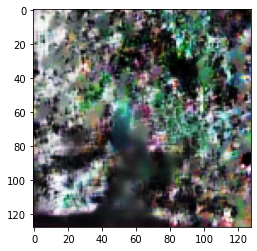

In [25]:
#display some images of label 1 (negative weeds)
n_row = 1
z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, latent_dim))))
    # Get labels ranging from 0 to n_classes for n rows
labels = np.array([1 for _ in range(n_row) for num in range(n_row)])
labels = Variable(LongTensor(labels))
gen_imgs = model(z, labels)


show_tensor_images(gen_imgs, 1, (32,32))

In [45]:
import torchvision.transforms as T
from PIL import Image
transform = T.ToPILImage()

In [76]:
from PIL import Image
numClasses = 9
n_row = 1
img_list = []
for i in range(9):
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, latent_dim))))
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([i for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    gen_imgs = model(z, labels)
    img = gen_imgs.data[0]
    img = transform(img)
    img_list.append(img)
    img.save(f"gen_images/generated_{i}.png")
 


